# GoFast

В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. В нашем распоряжении данные о пользователях: их уникальные id, имена, возраст, город и тип подписки; об их поездках: снова id, пройденное расстояние, длительность и дата поездки; а также о подписках: тип подписки, стоимость одной минуты, стоимость начала поездки и ежемесячный платеж.

Нам нужно определить поведение пользователей с подпиской и без: кто приносит больший доход, как часто они пользуются услугами сервиса, нужно ли проводить акцию с промокодами на 1 бесплатный месяц подписки и т.д.

**Цели исследования** - проверить три гипотезы:

- Пользователи с подпиской тратят на поездки больше времени
- Расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров
- Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

**Ход исследования:**

1. Обзор данных
2. Предобработка данных
3. Исследовательский анализ
4. Объедининение датафреймов для дальнейшего удобства
5. Подсчет ежемесячной выручки с каждого пользователя
6. Проверка выше описанных гипотез
7. Построение распределений и формулировка выводов
8. Общий вывод

In [1]:
# Импортируем нужные нам библиотеки и функции из них

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from math import factorial, sqrt

## Загрузка данных

In [2]:
# Читаем файлы и выводим общую информацию о каждом из них

users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


В таблице с пользователями 1565 строк, пропуски отсутствуют, названия столбцов соответствуют общепринятым стандартам, но в столбце с именами скорее всего есть неявные дубликаты, нужно будет это проверить на этапе предобработки.

In [3]:
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


В таблице с поездками 18068 строк, пропуски также отсутствуют,  названия столбцов соответствуют общепринятым стандартам. В столбце с датой нужно поменять тип данных на datetime.

In [4]:
subs.info()
subs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В таблице с подписками всего 2 строки, здесь все в порядке.

### Промежуточный вывод по общей информации

Были получены таблицы с информацией о пользователях, их поездках и о подписке. Пропусков не обнаружено. Названия столбцов соответствуют общепринятым стандартам.

## Предобработка данных

Для начала проверим столбец с именами на неявные дубликаты.

In [5]:
# Выводим список уникальных имен и ищем неявные дубликаты, затем устраняем их

# print(users['name'].sort_values().unique())
users['name'] = users['name'].replace({'Влад': 'Владислав', 'Наталья': 'Наталия', 'Наташа': 'Наталия'})
print(users['name'].sort_values().unique())

['Агата' 'Аделина' 'Адель' 'Айдар' 'Александр' 'Александра' 'Алексей'
 'Алина' 'Алиса' 'Алия' 'Алла' 'Альберт' 'Альбина' 'Алёна' 'Амалия'
 'Амина' 'Амир' 'Анастасия' 'Анатолий' 'Ангелина' 'Андрей' 'Анжелика'
 'Анна' 'Антон' 'Антонина' 'Ариана' 'Арина' 'Арсен' 'Арсений' 'Артемий'
 'Артур' 'Артём' 'Богдан' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия'
 'Варвара' 'Василий' 'Василина' 'Василиса' 'Вера' 'Вероника' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Виталина' 'Влада' 'Владимир' 'Владислав'
 'Владислава' 'Всеволод' 'Вячеслав' 'Галина' 'Георгий' 'Герман' 'Глеб'
 'Гордей' 'Григорий' 'Давид' 'Дамир' 'Даниил' 'Данил' 'Данила' 'Даниэль'
 'Дарина' 'Дарья' 'Демид' 'Денис' 'Диана' 'Дмитрий' 'Ева' 'Евгений'
 'Евгения' 'Егор' 'Екатерина' 'Елена' 'Елизавета' 'Елисей' 'Есения'
 'Жанна' 'Зарина' 'Захар' 'Злата' 'Иван' 'Игнат' 'Игорь' 'Ильдар' 'Илья'
 'Инна' 'Ирина' 'Камилла' 'Карина' 'Каролина' 'Кира' 'Кирилл' 'Константин'
 'Кристина' 'Ксения' 'Лариса' 'Лев' 'Леонид' 'Лиана' 'Лидия' 'Лилия'
 'Лю

Неявные дубликаты устранены, но практического смысла в этом нет, так как столбец с этими данными нам не понадобится.

Теперь проверим таблицы на явные дубликаты

In [6]:
print('Количество явных дубликатов  в таблице с пользователями:', users.duplicated().sum())
print('Количество явных дубликатов  в таблице с поездками:', rides.duplicated().sum())

Количество явных дубликатов  в таблице с пользователями: 31
Количество явных дубликатов  в таблице с поездками: 0


Обнаружено 31 явных дубликатов в таблице с пользователями, устраним их.

In [7]:
users = users.drop_duplicates()

# users.info() Проверим, были ли удалены явные дубликаты

Теперь изменим тип данных в столбце с датой в таблице с поездками и тут же создадим новый столбец с номером месяца.

In [8]:
# Изменяем типы данных

rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['month'] = pd.DatetimeIndex(rides['date']).month

# rides['year'] = pd.DatetimeIndex(rides['date']).year
# print(rides['year'].unique())

# rides.info() Проверим, как изменился тип данных

rides.head() 

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Теперь проверим данные на наличие аномальных значений.

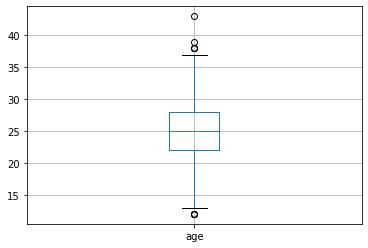

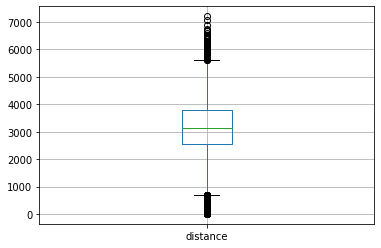

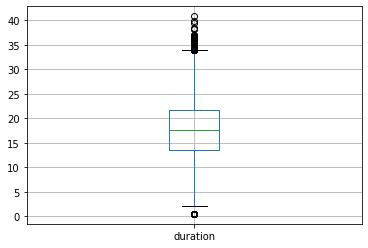

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [9]:
# Выводим диаграммы размаха и определяем выбросы, а также выводим общую характеристику некоторых столбцов

users.boxplot(column='age')
plt.show()

rides.boxplot(column='distance')
plt.show()

rides.boxplot(column='duration')
plt.show()

print(rides['distance'].describe())
rides['duration'].describe()

В столбце в возрастом пользователя аномальных значений нет. В столбце с пройденной дистанцией есть значения, меньшие 1 м, скорее всего это люди, которые впервые встали на самокат и передумали использовать его. Я думаю, что данные, где пройденная дистанция меньше 200 м можно считать нерелевантными. То же самое можно сказать и про столбец с длительностью поездки, там тоже есть значения, которые меньше минуты. Поэтому данные, где длительность меньше минуты можно считать нерелевантными. Очистим таблицу от этих значений.

In [10]:
# Фильтруем таблицу

rides = rides.query('distance >= 200')
rides = rides.query('duration >= 1')

rides.shape[0]

17803

После обработки аномальных значений было удалено 265 строк из 18068.

### Промежуточный вывод по этапу предобработки

Пропуски в данных полностью отсутствуют, в столбце с именами были устранены неявные дупликаты, в таблице с пользователями было удалено 31 явных дупликатов. Был изменен тип данных в столбце в датой на datetime, также был создан новый столбец с номером месяца. Были обнаружены и устранены аномальные значения в столбцах с дистанцией, меньшей 200 м, и длительностью поездки, меньшей 1 минуты. Было удалено 265 строк из 18068. 

## Исследовательский анализ данных

Теперь опишем и визуализируем общую информацию о пользователях и их поездках с помощью графиков.

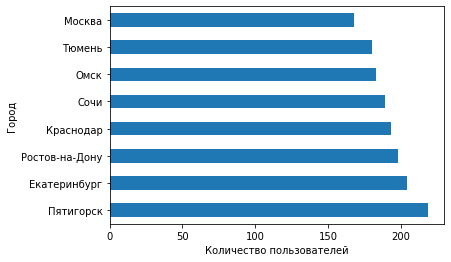

In [11]:
# Строим столбчатые диаграммы и гистограммы для анализа

users['city'].value_counts().plot(kind='barh')
plt.xlabel('Количество пользователей')
plt.ylabel('Город');

Больше всего пользователей из Пятигорска, их около 220, меньше всего в Москве - ~170. Количество пользователей равномерно уменьшается от Пятигорска к Москве.

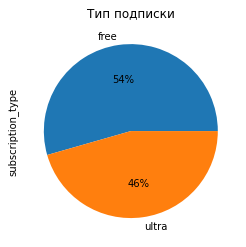

In [32]:
users['subscription_type'].value_counts().plot(title = 'Тип подписки', kind='pie', autopct = "%.0f%%");

Пользователи без подписки составляют чуть более половины от общего числа клиентов.

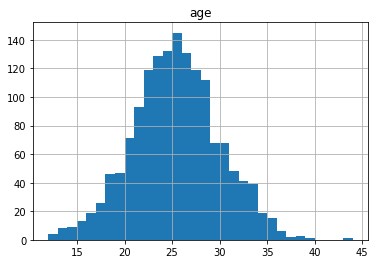

In [13]:
users.hist('age', bins=32, range=(12, 44));

Больше всего людей, которым 25 лет - их больше 140. Основной возрастной диапазон лежит в области от 18 до 34 лет. График похож на нормальное распределение.

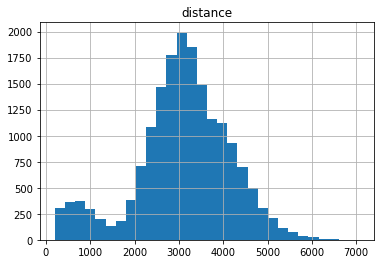

In [14]:
rides.hist('distance', bins=30);

В среднем каждая дистанция одной поездки лежит в диапазоне от 2 до 5 км. На левой стороне графика виден "бугорок": достаточно большое количество людей проезжает меньше 1.5 км, видимо эти люди неуверенно чувствовали себя на самокате на первых попытках.

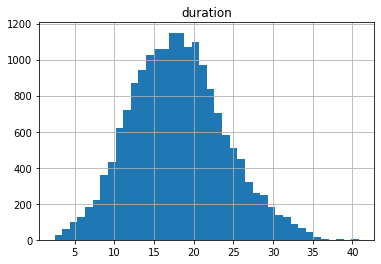

In [15]:
rides.hist('duration', bins=40);

В среднем одна поездка длится от 7 до 27 минут, больше всего поездок длительностью ~17 минут. Этот график также похож на график нормального распределения.

### Промежуточный вывод по этапу исследовательского анализа данных

Для описания частоты встречаемости городов и соотношения пользователей с подпиской и без подписки были построены столбчатые диаграммы. Для остальных параметров были построены гистограммы. Гистограммы с возрастом пользователей и длительностью поездки напоминают график нормального распределения. Больше всего пользователей в Пятигорске - ~220, пользователи без подписки составляют 54% от общего числа, основная возрастная категория - 25 лет. В основном дистанция одной поездки лежит в области от 2 до 5 км, ее средняя продолжительность лежит в диапазоне от 7 до 27 минут.

## Объединение данных

In [16]:
# Методом merge() объединяем сначала таблицу с пользователями и поездками, затем присоединяем таблицу с подписками

data = users.merge(rides, on='user_id', how='right')
data = data.merge(subs, on='subscription_type', how='left')

print('Итоговый размер таблицы:', data.shape[0])
data.head()

Итоговый размер таблицы: 17803


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Объединили все таблицы в одно целое, размер таблицы совпадает с размером таблицы о поездках, так как объединение происходило именно по этим данным. Теперь создадим еще 2 датафрейма: поездки пользователей с подпиской и без.

In [18]:
# Создаем 2 новых датафрейма по подпискам

data_u = data.query('subscription_type == "ultra"')
data_f = data.query('subscription_type == "free"')

Теперь посмотрим, как пройденное расстояние зависит от длительности поездки (очевидно что при увеличении длительности возрастет и расстояние)

Коэффициент корреляции Пирсона в таблице с подпиской равен 0.4933405982485452
Коэффициент корреляции Пирсона в таблице без подписки равен 0.602061594449847


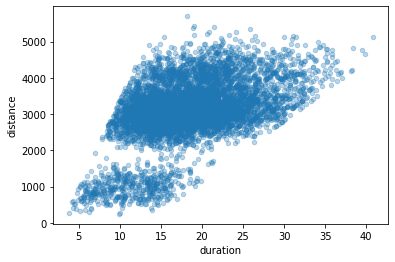

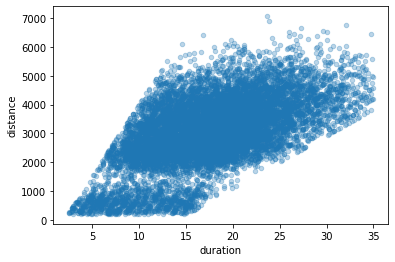

In [19]:
# Строим графики рассеяния и считаем коэффициент корреляции Пирсона

data_u.plot(x='duration',
            y='distance',
            kind='scatter',
            alpha=0.3)
print('Коэффициент корреляции Пирсона в таблице с подпиской равен', data_u['distance'].corr(data_u['duration']))

data_f.plot(x='duration',
            y='distance',
            kind='scatter',
            alpha=0.3)
print('Коэффициент корреляции Пирсона в таблице без подписки равен', data_f['distance'].corr(data_f['duration']))

Эти два графика очень похожи друг на друга, причем и там и там есть тот самый "бугорок", описанный на предыдущем этапе, здесь он выглядит так, как будто отрезает часть графика. Коэффициенты корреляции Пирсона говорят о том, что пройденная дистанция у пользователей без подписки сильнее зависит от длительности поездки, чем у пользователей с подпиской. Пользователи без подписки в целом проезжают более далекие расстояния. Теперь взглянем на гистограммы:

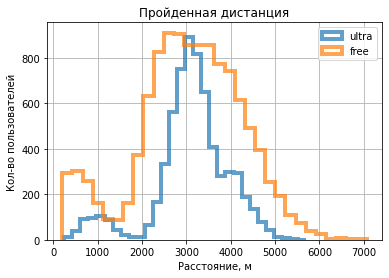

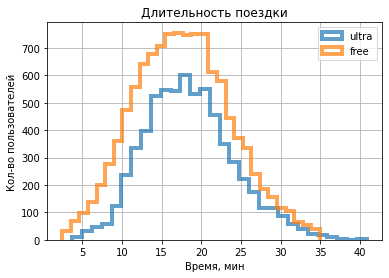

In [20]:
ax = data_u.hist('distance', bins=30, alpha=0.7, histtype='step', linewidth=4)
data_f.hist('distance', bins=30, alpha=0.7, histtype='step', ax=ax, linewidth=4)
plt.legend(['ultra', 'free'])
plt.title('Пройденная дистанция')
plt.xlabel('Расстояние, м')
plt.ylabel('Кол-во пользователей')

ax = data_u.hist('duration', bins=30, histtype='step', alpha=0.7, linewidth=4)
data_f.hist('duration', bins=30, alpha=0.7, histtype='step', ax=ax, linewidth=4)
plt.legend(['ultra', 'free'])
plt.title('Длительность поездки')
plt.xlabel('Время, мин')
plt.ylabel('Кол-во пользователей');

Снова виден "бугорок", среднее расстояние, которое проезжают пользователи с подпиской, находится в пределах от 2200 до 4400 м, но в основном длина пути равняется ~3 км, а длительность от 10 до 27 минут. 

Среднее расстояние, которое проезжают пользователи без подписки, находится в пределах от 2 до 5 км, но в основном длина пути также равняется ~3 км, а длительность от 8 до 27 минут.

### Промежуточный вывод по этапу объединения данных

Данные из всех таблиц были объединены по таблице с поездками, затем эти данные были разделены на два датафрейма: пользователи с подпиской и без. Были построенны графики для длительности поездок и их расстояния. По значениям коэффициента Пирсона можно предположить, что люди без подписки перемещаются на самокатах с чуть большей скоростью, потому что пройденное расстояние сильнее зависит от длительности поездки у пользователей без подписки, и в целом люди без подписки проезжают бо́льшее расстояние.

## Подсчёт выручки

Теперь посчитаем выручку с каждого пользователя за каждый месяц и заодно создадим новый столбец с выручкой за этот месяц.

In [21]:
# Определим функцию, которая считает выручку с каждого пользователя за каждый месяц

def income(row):
    if row['subscription_type'] == 'ultra':
        return row['subscription_fee'] + row['minute_price']*row['total_time']
    else:
        return row['start_ride_price']*row['rides'] + row['minute_price']*row['total_time']

# Создадим сводную таблицу по пользователям и месяцам, посчитаем общее пройденное расстояние и общее время, 
# а также укажем тип подписки, затем переименуем столбцы
    
data_pivot = data.pivot_table(index=['user_id', 'month'], 
                              values=['distance', 'duration', 'subscription_type', 'subscription_fee', 'minute_price',
                                      'start_ride_price'],
                              aggfunc={'distance': ['sum', 'count'], 'duration': 'sum', 'subscription_type': 'min', 
                                       'subscription_fee': 'min', 'minute_price': 'min', 'start_ride_price': 'min'})
data_pivot.columns = ['rides', 'total_distance', 'total_time', 'minute_price', 'start_ride_price', 'subscription_fee',
                      'subscription_type']
data_pivot['total_time'] = round(data_pivot['total_time'])
data_pivot['income'] = data_pivot.apply(income, axis=1)

data_pivot.head() # Смотрим как выглядит таблица

rides  total_distance  total_time  minute_price  \
user_id month                                                    
1       1          2     7027.511294        41.0             6   
        4          1      754.159807         6.0             6   
        8          2     6723.470560        45.0             6   
        10         2     5809.911100        32.0             6   
        11         3     7003.499363        53.0             6   

               start_ride_price  subscription_fee subscription_type  income  
user_id month                                                                
1       1                     0               199             ultra   445.0  
        4                     0               199             ultra   235.0  
        8                     0               199             ultra   469.0  
        10                    0               199             ultra   391.0  
        11                    0               199             ultra   517.0

### Промежуточный вывод по этапу подсчета выручки

Был создан новый датафрейм, произошло объединение по столбцам с id пользователя и месяцу, были рассчитаны общее пройденное расстояние, общее время, количество поездок и указан тип подписки в каждый месяц пользования сервисом. После этого был создан новый столбец, в котором была посчитана выручка за данный месяц.

## Проверка гипотез

Проверим гипотезу о том, что пользователи с подпиской тратят на поездки больше времени.

- **Нулевая гипотеза:** средняя длительность поездки у пользователей с подпиской и без одинакова
- **Альтернативная гипотеза:** средняя длительность поездки у пользователей с подпиской больше

In [23]:
# Проводим Т-тест с двумя независимыми выборками с уровнем статистической значимости 1%

print('Среднее время с подпиской:', data_u['duration'].mean(), 'минут')
print('Среднее время без подписки:', data_f['duration'].mean(), 'минут', '\n')

alpha = 0.01

results = st.ttest_ind(data_u['duration'], data_f['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее время с подпиской: 18.54198516280583 минут
Среднее время без подписки: 17.671426075019415 минут 

p-значение: 1.4786520876299893e-21
Отвергаем нулевую гипотезу


Действительно, значение p-value говорит о том, что нулевая гипотеза о равенстве средних двух выборок отвергается, они различаются, хоть и ненамного. Пользователи с подпиской тратят на поездки больше времени, чем пользователи без подписки.

Теперь проверим гипотезу о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров.

- **Нулевая гипотеза:** среднее расстояние, пройденное пользователями с подпиской, равно 3130 м
- **Альтернативная гипотеза:** среднее расстояние, пройденное пользователями с подпиской, меньше 3130 м

In [24]:
# Проводим Т-тест с одной выборкой с уровнем статистической значимости 1%

print('Среднее расстояние с подпиской:', data_u['distance'].mean(), '\n')

avg_dist = 3130

alpha = 0.01

results = st.ttest_1samp(data_u['distance'], avg_dist, alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Среднее расстояние с подпиской: 3115.4453880370247 

p-значение: 0.08046311521502146
Не отвергаем нулевую гипотезу


Значение p-value говорит о том, что наша гипотеза возможно неверна, но ее нельзя отвергать, пользователи с подпиской в среднем за одну поездку проезжают 3115 м. Можно сказать, что износ самокатов будет происходить оптимально.

Теперь проверим гипотезу о том, будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

In [25]:
# Проводим Т-тест с двумя независимыми выборками с уровнем статистической значимости 1%

print('Средняя выручка с подпиской:', 
      round(data_pivot.query('subscription_type == "ultra"')['income'].mean()), 'руб./месяц')
print('Средняя выручка без подписки:', 
      round(data_pivot.query('subscription_type == "free"')['income'].mean()), 'руб./месяц', '\n')

alpha = 0.01

results = st.ttest_ind(data_pivot.query('subscription_type == "ultra"')['income'], 
                       data_pivot.query('subscription_type == "free"')['income'],
                       alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя выручка с подпиской: 359 руб./месяц
Средняя выручка без подписки: 322 руб./месяц 

p-значение: 2.8328384289170743e-37
Отвергаем нулевую гипотезу


Действительно, значение p-value говорит о том, что нулевую гипотезу о равенстве средних двух независимых выборок можно отвергнуть. Средняя выручка с подпиской - 359 руб./месяц, очевидно больше, чем без подписки - 322 руб./месяц.

Теперь представим, что техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значительно снизится. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Здесь для проверки гипотезы о том, что после обновления серверов количество обращений в поддержку сократится, нам бы понадобился метод scipy.stats.ttest_rel() для проверки гипотезы о равенстве средних двух зависимых выборок.

### Промежуточный вывод по этапу проверки гипотез

Были проверены три гипотезы и описан метод проверки четвертой гипотезы, а также сделаны следующие выводы:

- Пользователи с подпиской приносят больше выручки: в среднем с каждого пользователя 359 руб/месяц
- Они также больше пользуются самокатами: в среднем на 1 минуту больше
- Износ самокатов будет происходить оптимально: среднее пройденное расстояние равно 3115 м

## Распределения

Теперь с помощью распределения определим, какое количество промокодов с бесплатной подпиской на один месяц нужно разослать пользователям, чтобы вероятность не выполнить план была примерно 5%.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Искомое количество промокодов: 1172
Вероятность не выполнить план: 0.04954795210203071 %


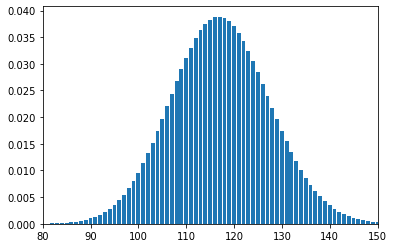

In [26]:
# Перебираем все n, начиная со 100, так как нас интересует минимум 100 успехов, затем строим график

n = 100
p = 0.1
    
while st.binom.cdf(100, n, p) > 0.05:
    n += 1

distr = []

# Заполняем пустой список значениями вероятности

for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.xlim(80, 150)

print('Искомое количество промокодов:', n)    
print('Вероятность не выполнить план:', st.binom.cdf(100, n, p), '%')

Чтобы вероятность выполнить план была больше 95%, нужно разослать минимум 1172 промокода.

Теперь посмотрим, с какой вероятностью 399500 пользователей не откроют push-уведомление, если будут разосланы 1 млн. таких уведомлений.

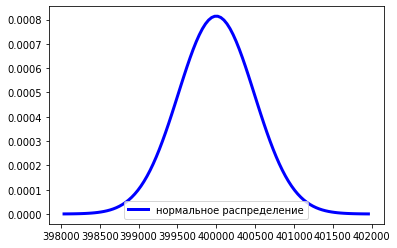

Условие аппроксимации выполняется
Вероятность того, что уведомление откроют менее 399500 пользователей: 15.37 %


In [27]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, st.norm.pdf(x, mu, sigma), 'b-', lw=3, label='нормальное распределение')

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='lower center')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие аппроксимации выполняется')
else:
    print('Условие аппроксимации не выполняется')

distr = st.norm(mu, sigma) # задаем нормальное распределение

print('Вероятность того, что уведомление откроют менее 399500 пользователей:', round(distr.cdf(399500)*100, 2), '%')

### Промежуточный вывод по этапу распределений

Для исследования было построено два распределения, оба биномиальных, но второе было аппроксимированно нормальным распределением, были сделаны следующие выводы:

- Для того, чтобы как минимум 100 пользователей с вероятностью 95% продлили подписку, нужно разослать минимум 1172 промокода;
- Если разослать 1 млн. push-уведомлений, то с вероятностью 15.37% их откроют менее 399500 пользователей.

## Общий вывод

Было проведено исследование данных из сервиса по прокату самокатов **"GoFast"**

Пропусков в данных не было обнаружено, были выявлены явные дубликаты в количестве 31 строки в таблице с пользователями, которые затем были удалены, а также неявные  в столбце с именами, но их устранение никак не повлияло на исследование. 

Были обнаружены аномальные значения в таблице с поездками: 
люди проезжали менее 10 м в течение 30 секунд, скорее всего эти люди с непривычки или из-за боязни нанести своему здоровью вред отказались пользоваться самокатом, который может двигаться с достаточно большой скоростью. 

Поэтому эти данные были нерелевантны для нашего исследования и таблица была отфильтрована: 
было удалено 268 строк из 18068.

После проведения исследовательского анализа данных было выявлено следующее:

- Больше всего пользователей в Пятигорске
- Пользователи без подписки составляют 54% от общего числа
- В основном дистанция одной поездки лежит в области от 2 до 5 км, ее средняя продолжительность лежит в диапазоне от 7 до 27 минут.
- Самокатами в основном пользуется молодежь от 20 до 28 лет

Для удобства были объединены все таблицы: таблица с пользователями, поездками и подписками. Затем из этих же таблиц было получено еще два датафрейма о пользователях с подпиской и без.

Затем была создана новая таблица для подсчета выручки, для каждого клиента было посчитано пройденное им расстояние и общее время пользования самокатом за каждый месяц с учетом наличия подписки.

Далее были проверены три гипотезы и возможной вариант проверки четвертой:

- Гипотеза о том, что пользователи с подпиской тратят на поездки больше времени: был проведен т-тест с двумя независимыми выборками, и , действительно, пользователи с подпиской тратят на поездку больше времени - больше на 1 минуту.
- Гипотеза о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров: полученное значение p-value говорит о том, что эта гипотеза возможно неверна, но ее все равно нельзя отвергать, пользователи с подпиской в среднем за одну поездку проезжают 3115 м. Можно сказать, что износ самокатов будет происходить оптимально.
- Гипотеза о том, будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки: значение p-value говорит о том, что нулевую гипотезу о равенстве средних двух независимых выборок можно отвергнуть. Средняя выручка с подпиской - 359 руб./месяц, очевидно больше, чем без подписки - 322 руб./месяц.
- Для проверки гипотезы о том, что после обновления серверов количество обращений в поддержку сократится, нам бы понадобился метод scipy.stats.ttest_rel() для проверки гипотезы о равенстве средних двух зависимых выборок.

Далее были построены биномиальные распределения для ответа на 2 вопроса:
- Для того, чтобы как минимум 100 пользователей с вероятностью 95% продлили подписку, нужно разослать минимум 1172 промокода;
- Если разослать 1 млн. push-уведомлений, то с вероятностью 15.37% их откроют менее 399500 пользователей.

Общие рекомендации: стоит продвигать платную подписку, так как такие пользователи приносят больше выручки, но, даже не смотря на бесплатный старт поездки и уменьшенную плату за 1 минуту, самокаты изнашиваюся оптимально и не стоит переживать по поводу покупки экстренной партии новых самокатов. Для привлечения интереса к подписке можно разослать примерно 1200 промокодов, и практически со 100% вероятностью можно рассчитывать на 100 новых подписчиков. Но такие предложения стоит отправлять в основном людям с возрастной категорией от 20 до 28 лет.